In [79]:
import modin.pandas as mpd
import pandas as pd
import numpy as np
import numba as nb
import math
import datetime
import collections
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pymysql
from sklearn.linear_model import LinearRegression

In [80]:
 def conn():
    conn_jydb = pymysql.connect(
        host = '10.224.16.81',
        port = 3306,
        user = 'haquant',
        password = 'haquant',
        database = 'jydb',
        charset = 'utf8mb4')
    return conn_jydb

In [81]:
sql1 = """
        SELECT
            wind_code, tradedate, pettm
        FROM
            stockvaluation
        """
sql2 = """
        SELECT
            wind_code, tradedate, closeprice, changepct, negotiablemv, firstindustryname, firstindustrycode
        FROM
            dailydata
        """
sql3 = """
        SELECT
           wind_code, tradedate, Beta, BooktoPrice, Leverage, EarningsYield, Growth, Liquidity, Momentum, ResidualVolatility, Size, NonLinearSize
        FROM
            barra_cne5_factor
        """

In [82]:
%%time
#--读取数据
conn_jydb = conn()
df_stockvaluation = pd.read_sql_query(sql1, conn_jydb, index_col = ['wind_code', 'tradedate'])

CPU times: total: 2min 33s
Wall time: 2min 40s


In [83]:
%%time
#--读取数据
df_dailydata = pd.read_sql_query(sql2, conn_jydb, index_col = ['wind_code', 'tradedate'])

CPU times: total: 3min 57s
Wall time: 3min 58s


In [84]:
%%time
#--读取数据
df_barra = pd.read_sql_query(sql3, conn_jydb, index_col = ['wind_code', 'tradedate'])

CPU times: total: 6min 10s
Wall time: 6min 11s


In [85]:
%%time
#--数据深度复制、排序并删除空值
stockvaluation = df_stockvaluation.copy(deep = True).sort_index()
dailydata = df_dailydata.copy(deep = True).sort_index()
barra = df_barra.copy(deep = True).sort_index()

CPU times: total: 23 s
Wall time: 23 s


In [86]:
def coerce_numeric(s):
    try:
        return float(s)
    except:
        return -np.inf

In [87]:
def drop_na(dta, fac):
    '''
        缺失值处理：处理负无穷和缺失值NaN
    '''
    #处理原始数据中的负无穷（-Inf）
    try:
        dta.loc[:, fac] = dta[[fac]].applymap(coerce_numeric)
    except:
        dta.loc[:, fac] = dta[fac].apply(coerce_numeric)
        
    #缺失值处理
    dta = dta.loc[~dta[fac].isna(), :].copy()
    dta[fac].replace(np.inf, 0, inplace = True)
    
    return dta

In [88]:
def neutralize(dta, fac, X):
    '''
        中性化：因子暴露度对行业哑变量和对数流通市值做线性回归，
        取残差作为新的因子暴露度
    '''
    Y = dta[[fac]]
    X = X.loc[Y.index]
    #OLS矩阵解析式
    #beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y).T
    #residue = Y - np.dot(X, beta.T)
    
    model = LinearRegression(fit_intercept = False)
    res = model.fit(X, Y)
    coef = res.coef_
    residue = Y - np.dot(X, coef.T)
    
    assert len(dta.index.difference(residue.index)) == 0
    
    dta.loc[residue.index, [fac]] = residue
    return dta

In [89]:
def regression(dta, fac, y, X, intercept=False):
    
    df = dta.copy(deep = True)
    dfy = df[[y]]
    dfX = df[[X]]
    
    if intercept:
        dfX = sm.add_constant(dfX)
    model = sm.WLS(dfy, dfX, weights=1)
    result = model.fit()
    
    ts, params = result.tvalues, result.params
    ts.index = dfX.columns
    params.index = dfX.columns
    err = pd.DataFrame(np.dot(dfX, params).T, index = dfy.index, columns = ['e'])
    residue = dfy[y] - err['e']
    
    assert len(df.index.difference(residue.index)) == 0
    
    df.loc[residue.index, [fac]] = residue
    
    return df

In [90]:
def EPA_reg(dta, fac):
    df = dta.copy(deep = True)
    dfy = df[['EPDS']]
    dfX = df[['EarningsYield', 'Momentum', 'ResidualVolatility']]
    
    model = sm.WLS(dfy, dfX, weights=1)
    result = model.fit()
    
    ts, params = result.tvalues, result.params
    ts.index = dfX.columns
    params.index = dfX.columns
    err = pd.DataFrame(np.dot(dfX, params).T, index = dfy.index, columns = ['e'])
    residue = dfy['EPDS'] - err['e']
    
    assert len(df.index.difference(residue.index)) == 0
    
    df.loc[residue.index, [fac]] = residue
    
    return df

In [91]:
def EPD(dta):
    '''
        计算EPD因子，并对因子进行行业、市值中性化处理
        识别当前估值显著偏离历史中枢，处于异常区间的股票
    '''
    global dailydata
    #计算估值偏离因子EPD
    df = dta.copy(deep = True)
    df['EP'] = 1 / df['pettm']
    df[['drop', 'std_EP252']] = df.groupby(level = 0, as_index = False)['EP'].rolling(252).std()
    df.drop('drop', axis = 1, inplace = True)
    df[['drop', 'mu_EP252']] = df.groupby(level = 0, as_index = False)['EP'].rolling(252).mean()
    df.drop('drop', axis = 1, inplace = True)
    df['EP_d'] = (df['EP'] - df['mu_EP252']) / df['std_EP252']
    
    #缺失值处理
    df = drop_na(df, fac = 'EP_d')
    
    #创建中信一级行业哑变量0/1矩阵
    ind_dummy_matrix = pd.get_dummies(dailydata['firstindustryname'])
    lncap = np.log(dailydata[['negotiablemv']])
    df_X = pd.concat([lncap.loc[df.index, :], ind_dummy_matrix.loc[df.index, :]], axis = 1)
    
    #行业、市值中性化处理
    df = df.groupby(level = 'tradedate').apply(neutralize, fac = 'EP_d', X = df_X) #改写成并行方式提速
    
    return df

In [92]:
def EPDS(dta):
    '''
        削弱个股层面估值逻辑改变带来的影响
        寻找估值逻辑被改变的代理变量
    '''
    #计算估值缓慢偏离因子EPDS
    global dailydata
    
    df = dta.copy(deep = True)
    daily = dailydata.copy(deep = True)
    
    #构建信息比率IR（衡量股票估值逻辑被改变的概率）
    daily[['drop', 'mu_r126']] = daily.groupby(level = 0, as_index = False)['changepct'].rolling(126).mean()
    daily.drop('drop', axis = 1, inplace = True)
    daily[['drop', 'sigma_r126']] = daily.groupby(level = 0, as_index = False)['changepct'].rolling(126).std()
    daily.drop('drop', axis = 1, inplace = True)
    daily['IR'] = daily['mu_r126'] / daily['sigma_r126']
    
    #回归法计算估值缓慢偏离因子EPDS
    y = df[['EP_d']].copy()
    X = daily.loc[df.index, ['IR']].copy()
    
    #处理缺失值
    y = drop_na(y, fac = 'EP_d')
    X = drop_na(X, fac = 'IR')
    
    #处理数据长度
    new_df = pd.concat([y, X], axis = 1)
    new_df.dropna(axis = 0, how = 'any', inplace = True)
    new_df = new_df.groupby(level = 'tradedate').apply(regression, fac = 'EPDS', 
                                                       y = 'EP_d', X = 'IR', intercept = True)
    
    return new_df

In [93]:
def EPA(dta):
    '''
        为了剔除行业与风格的影响，每月月底将EPD、EPDS因子
        与对Barra风格与一级行业哑变量进行回归，残差作为选股因子
    '''
    #计算纯因子EPA
    global dailydata, barra
    
    df = dta.copy(deep = True)
    daily = dailydata[['closeprice', 'changepct', 'firstindustryname']].copy(deep = True)
    bar = barra[['EarningsYield', 'Momentum', 'ResidualVolatility']].copy(deep = True)
    
    #回归法计算估值缓慢偏离因子EPDA
    new_df = pd.concat([df, bar], axis = 1, join = 'inner')
    new_df.dropna(axis = 0, how = 'any', inplace = True)
    new_df = new_df.groupby(level = 'tradedate').apply(EPA_reg, fac = 'EPA')
    return new_df

In [94]:
%%time
#计算估值偏离因子EPD
EP_d = EPD(stockvaluation)

CPU times: total: 4min 57s
Wall time: 4min 59s


In [95]:
%%time
#将因子处理成面板形式，行为股票代码，列为交易日期
factor_EPD = pd.DataFrame()
factor_EPD['EPD'] = EP_d[['EP_d']].copy(deep = True)
factor_EPD = factor_EPD.unstack(level='tradedate')
factor_EPD.dropna(axis = 0, how = 'any', inplace = True)

CPU times: total: 6.7 s
Wall time: 6.73 s


In [96]:
%%time
factor_EPD.to_csv('C:/Users/hazc/Desktop/data/EPD.csv')

CPU times: total: 7.41 s
Wall time: 7.4 s


In [97]:
%%time
#计算估值缓慢偏离因子EPDS
df_EPDS = EPDS(EP_d)

CPU times: total: 4min 31s
Wall time: 4min 32s


In [98]:
%%time
#将因子处理成面板形式，行为股票代码，列为交易日期
factor_EPDS = pd.DataFrame()
factor_EPDS['EPDS'] = df_EPDS[['EPDS']].copy(deep = True)
factor_EPDS = factor_EPDS.unstack(level='tradedate')
factor_EPDS.dropna(axis = 0, how = 'any', inplace = True)

CPU times: total: 6.45 s
Wall time: 6.62 s


In [99]:
%%time      
factor_EPDS.to_csv('C:/Users/hazc/Desktop/data/EPDS.csv')

CPU times: total: 6.88 s
Wall time: 6.89 s


In [100]:
%%time
df_EPA = EPA(df_EPDS)

CPU times: total: 3min 4s
Wall time: 3min 7s


In [101]:
%%time
#将因子处理成面板形式，行为股票代码，列为交易日期
factor_EPA = pd.DataFrame()
factor_EPA['EPA'] = df_EPA[['EPA']].copy(deep = True)
factor_EPA = factor_EPA.unstack(level='tradedate')
factor_EPA.dropna(axis = 0, how = 'any', inplace = True)

CPU times: total: 6.14 s
Wall time: 6.21 s


In [102]:
%%time      
factor_EPA.to_csv('C:/Users/hazc/Desktop/data/EPA.csv')

CPU times: total: 6.47 s
Wall time: 6.47 s


In [103]:
%%time
factor = df_EPA[['EP_d', 'EPDS', 'EPA']].copy(deep = True)
factor.columns = ['EPD', 'EPDS', 'EPA']
factor_book = pd.concat([factor, dailydata[['closeprice', 'changepct']]], axis = 1, join = 'inner')
factor_book.to_csv('C:/Users/hazc/Desktop/data/factor_book.csv')

CPU times: total: 2min 26s
Wall time: 2min 28s


In [104]:
def MaxDrawdown(return_list):
    i = np.argmax((np.maximum.accumulate(return_list) - return_list))
    if i == 0:
        return 0
    j = np.argmax(return_list[:i])  # 开始位置
    drawdown_max = return_list[j] - return_list[i]
    drawdown_rate = (return_list[i] - return_list[j]) / return_list[j] * 100
    drawdown_month = i - j
    return drawdown_rate

In [105]:
def draw(dta, factor):
    df = dta.copy(deep = True)
    
    # 设置中文字体
    plt.rcParams['axes.unicode_minus'] = False    # 不使用中文减号
    plt.rcParams['font.sans-serif'] = 'FangSong'  # 设置字体为仿宋（FangSong）

    # 画布
    fig = plt.figure(figsize=(10,4.5),  # inches
                     dpi=120, # dot-per-inch
                     facecolor='#BBBBBB',
                     frameon=False, # 画布边框
                    )  

    # 中文标题
    title = factor + '因子的5分组及多空对冲净值走势'
    plt.title(title)


    # 字体字典
    font_dict=dict(fontsize=8,
                  color='k',
                  family='SimHei',
                  weight='light',
                  style='italic',
                  )

    X = pd.to_datetime(df.index)
    Y = df.loc[:,]
    plt.plot(X, Y)

In [106]:
class Fama_regression:
    def __init__(self, return_data, factor_data, freq = 'm'):
        # return_data: T*N, factor_data: T*1, freq = 'd', 'm', 'y'
        self.T, self.N = return_data.shape[0], return_data.shape[1]
        self.stock = return_data.columns #股票池
        self.time = return_data.index #时间
        self.return_data = return_data #股票收益率矩阵
        self.factor_data = factor_data #因子收益率矩阵
        if freq == 'd':
            self.time_period = 250
        elif freq == 'm':
            self.time_period = 12
        else:
            self.time_period = 1
    
    def time_series_regression_all_sample(self):  # 全样本时间序列回归
        def time_series_regression(Y):
            Y = Y.values
            Y[np.isnan(Y)] = 0
            X = self.factor_data.values
            constant = np.array([[1]] * len(self.time))
            X = np.hstack((constant, X))
            beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y).T[1]  # OLS矩阵求解式
            return beta
        self.factor_loading_allsample = self.return_data.apply(time_series_regression)
        return

    def fama_macbeth_regression_without_intercept(self,data_type='allsample'):  # Fama-macbeth回归
        #data_type为rolling（滚动回归数据），allsample（全样本回归数据）
        def section_regression_epsilion(Y):
            X = self.factor_loading_allsample
            N = len(X)
            X = np.array([X.values.tolist()]).T
            Y = np.array([Y.values.tolist()]).T
            beta = ((X.T.dot(Y)) / (X.T.dot(X)))[0][0]
            epsilon = Y - beta * X
            epsilon = epsilon.T[0]
            return pd.Series(epsilon, index=self.stock)

        def section_regression_beta(Y):
            X = self.factor_loading_allsample
            N = len(X)
            X = np.array([X.values.tolist()]).T
            Y = np.array([Y.values.tolist()]).T
            beta = ((X.T.dot(Y)) / (X.T.dot(X)))[0][0]
            epsilon = Y - beta * X
            T_test = beta / np.sqrt(epsilon.T.dot(epsilon) / (X.T.dot(X)) / (N - 1))[0][0]
            return pd.Series([beta, T_test], index=['beta', 'tvalue'])
        
        time_list = self.time
        
        return_data = self.return_data.loc[time_list]
        self.epsilon_mat = return_data.apply(section_regression_epsilion, axis=1)
        self.epsilon_mean = self.epsilon_mat.apply(np.mean)
        self.beta_tvalue = return_data.apply(section_regression_beta, axis=1)
        self.beta_fama, self.tvalue_fama = self.beta_tvalue['beta'], self.beta_tvalue['tvalue']
        return

    def compute_factor_characteristic(self):
        self.factor_tvalue=(self.beta_fama.mean()/self.beta_fama.std())*np.sqrt(len(self.beta_fama)-1)
        self.mean_tvalue=self.tvalue_fama.mean()
        self.mean_abs_tvalue=np.mean(np.abs(self.tvalue_fama))
        self.tvalue_morethan2=(self.tvalue_fama.abs()>2).sum()/len(self.tvalue_fama)
        print("因子t值: ", round(self.factor_tvalue, 2))
        print("平均t值: ", round(self.mean_tvalue, 2))
        print("平均绝对t值: ", round(self.mean_abs_tvalue, 2))
        print("绝对t值>2占比: ", round(self.tvalue_morethan2, 2))
        return

In [107]:
def backtest(dta, factor):
    df_test = dta.copy(deep = True)
    
    #月频因子计算
    df = df_test[[factor]].copy()
    df1 = df.reset_index()
    df1['ym'] = df1['tradedate'].astype(str).str[:7]
    df1['y'] = df1['tradedate'].astype(str).str[:4]
    df1 = df1.drop(df1[df1['y'].astype(int)<2010].index).copy()
    df2 = df1.groupby(['wind_code', 'ym']).last().copy()
    df2 = df2.drop(['y'], axis = 1)
    
    #收益率计算
    df_chg = df_test[['changepct']].copy()
    df_chg['changepct'] += 100
    df_chg['changepct'] /= 100
    df_chg1 = df_chg.reset_index().copy()
    df_chg1['ym'] = df_chg1['tradedate'].astype(str).str[:7]
    df_chg1['value'] = df_chg1.groupby(['wind_code', 'ym']).cumprod()
    df_chg2 = df_chg1.groupby(['wind_code', 'ym']).last().copy()
    df_chg2 = df_chg2.drop('changepct', axis = 1)
    
    #月频因子、下月收益率rt1
    test_IC = pd.concat([df2, df_chg2[['value']]], axis = 1, join = 'inner')
    test_IC = test_IC.reset_index().copy()
    test_IC['rt1'] = test_IC.groupby(['wind_code'])['value'].shift(-1)
    test_IC = test_IC.set_index(['wind_code', 'ym']).sort_index()
    test_IC = test_IC.dropna(axis = 0, how = 'any')
    
    #回测-绩效指标
    ic = test_IC.groupby(level = 1)[[factor, 'rt1']].corr(method = 'pearson').iloc[0::2, -1]
    rank_ic = test_IC.groupby(level = 1)[[factor, 'rt1']].corr(method = 'spearman').iloc[0::2, -1]
    icir = ic.mean() / ic.std() * math.sqrt(12)
    rank_icir = rank_ic.mean() / rank_ic.std() * math.sqrt(12)
    print('IC: ', round(ic.mean(), 2), ' Rank_IC: ', round(rank_ic.mean()*100, 2),'%', ' ICIR: ', round(icir, 2), 
          ' Rank_ICIR: ', round(rank_icir, 2))
    
    #回测-多空分组
    test = test_IC.sort_values(['ym', factor], ascending = [True, False]).copy()
    res = pd.DataFrame(columns = ['1', '2', '3', '4', '5', '1-5'])
    test_grouped = test.groupby(['ym'])
    for i, group in test_grouped:
        num = round(group.shape[0] / 5)
        g1 = group.iloc[0:num]['rt1'].mean()
        g2 = group.iloc[num:num*2]['rt1'].mean()
        g3 = group.iloc[num*2:num*3]['rt1'].mean()
        g4 = group.iloc[num*3:num*4]['rt1'].mean()
        g5 = group.iloc[num*4:]['rt1'].mean()
        g6 = g1 - g5 + 1
        res.loc[i] = {'1':g1, '2':g2, '3':g3, '4':g4, '5':g5, '1-5':g6}
    res['1'] = res['1'].cumprod()
    res['2'] = res['2'].cumprod()
    res['3'] = res['3'].cumprod()
    res['4'] = res['4'].cumprod()
    res['5'] = res['5'].cumprod()
    res['1-5'] = res['1-5'].cumprod()
    rt = (pow(res.iloc[-1, -1], 1/15) - 1) * 100
    print('年化收益率: ', round(rt, 2), '%')
    
    #回测-最大回撤
    max_drawback = MaxDrawdown(res['1-5'])
    print('最大回撤率: ', round(max_drawback, 2), '%')
    
    #回测-t值
    fac_data = res[['1-5']]
    ret_data = test_IC[['rt1']].unstack(level=0)
    factor_class = Fama_regression(return_data= ret_data, factor_data= fac_data, freq= 'm')
    factor_class.time_series_regression_all_sample()
    factor_class.fama_macbeth_regression_without_intercept()
    factor_class.compute_factor_characteristic()
    
    #画图
    draw(dta = res, factor = factor)

IC:  0.04  Rank_IC:  5.22 %  ICIR:  2.64  Rank_ICIR:  3.18
年化收益率:  13.07 %
最大回撤率:  -2.6 %
因子t值:  14.95
平均t值:  28.27
平均绝对t值:  28.6
绝对t值>2占比:  0.86
CPU times: total: 1min
Wall time: 1min


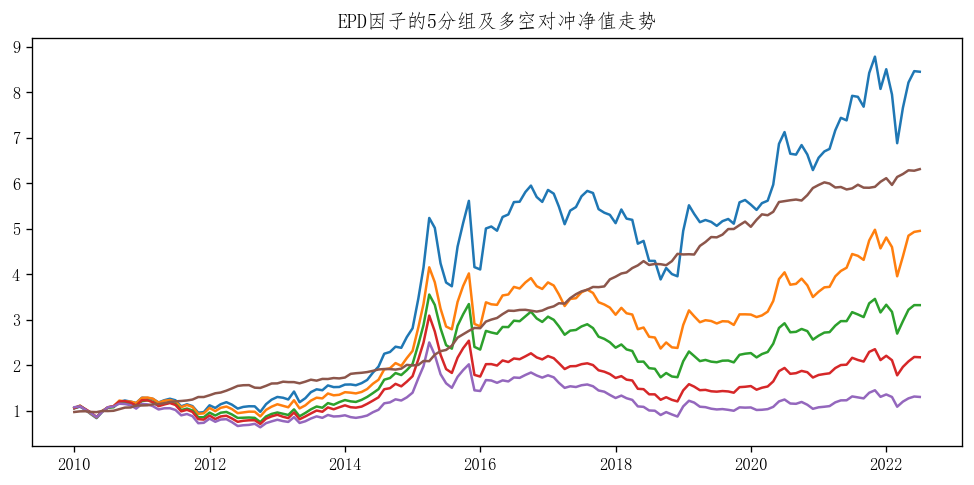

In [108]:
%%time
#因子回测-EPD
backtest(factor_book, factor = 'EPD')

IC:  0.04  Rank_IC:  4.86 %  ICIR:  2.69  Rank_ICIR:  3.32
年化收益率:  12.5 %
最大回撤率:  -2.36 %
因子t值:  14.9
平均t值:  28.17
平均绝对t值:  28.49
绝对t值>2占比:  0.86
CPU times: total: 1min
Wall time: 1min


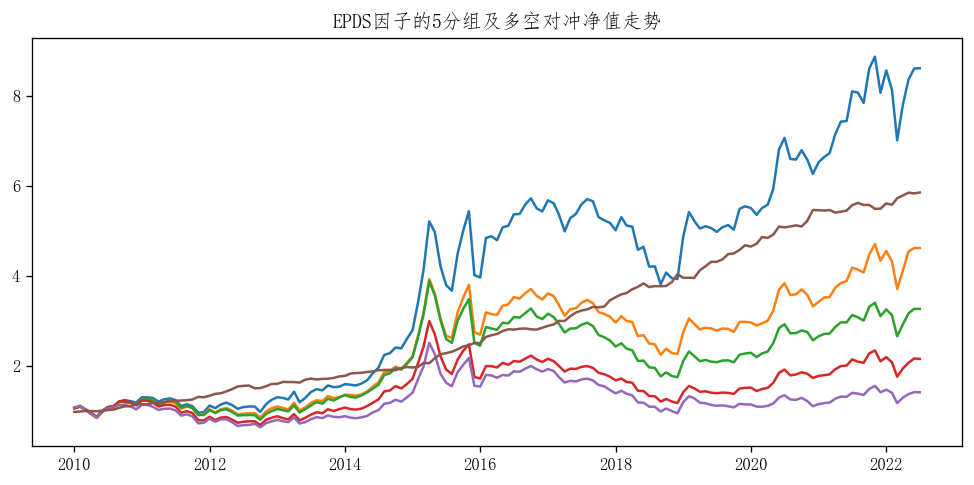

In [109]:
%%time
#因子回测-EPDS
backtest(factor_book, factor = 'EPDS')

IC:  0.03  Rank_IC:  4.28 %  ICIR:  2.76  Rank_ICIR:  2.99
年化收益率:  11.2 %
最大回撤率:  -2.04 %
因子t值:  15.45
平均t值:  29.43
平均绝对t值:  29.75
绝对t值>2占比:  0.87
CPU times: total: 1min
Wall time: 1min


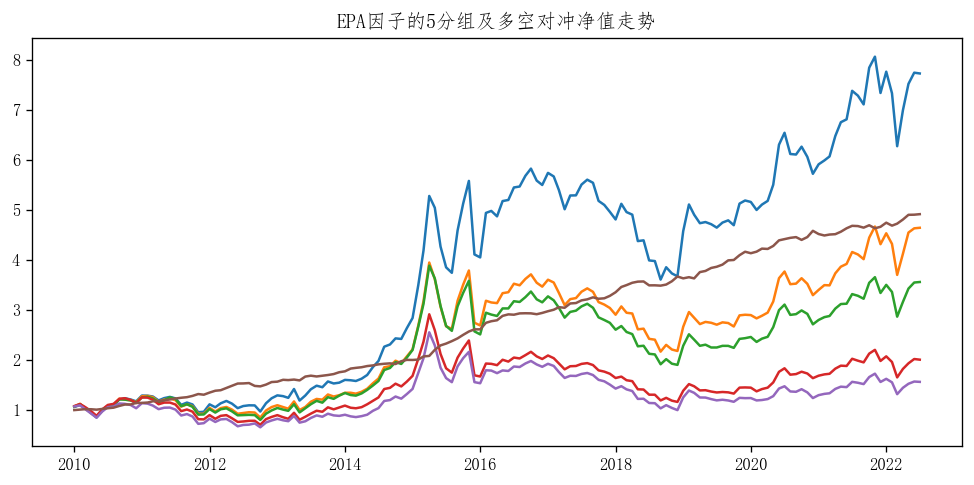

In [110]:
%%time
#因子回测-EPA
backtest(factor_book, factor = 'EPA')

In [111]:
#--关闭MySQL Connection
conn().close()